In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cmocean as cmo
import netCDF4 as nc
from scipy import spatial as spat

In [13]:
import sys
sys.path.append('../')
from src import data

# Get Substrate Data from GOM Files

Get data from GOM files on Poseidon server 

In [18]:
gom_fname = "../../../gom3_hourly/gom3_197800.nc"
sed_fname = "../auxdata/sediments.nc"

lon, lat, nv = data.get_latlon(gom_fname)
sed = data.get_substrate(sed_fname)
sub = data.standardize_to_centers(sed, nv)

In [35]:
coords = np.empty(shape=(2, 90415))
coords[0] = lon
coords[1] = lat
coords = coords.T

In [37]:
coord_tree = spat.cKDTree(coords)

# ECOMON Plankton Data Preliminary Analysis

Exploratory data analysis on ECOMON plankton data needed to determine the suitability of this dataset for creation of a GAM on various environmental parameters to predict spawning suitability at a location.

In [39]:
ecomon_data = pd.read_csv("https://www.nodc.noaa.gov/archive/arc0143/0187513/1.1/data/0-data/EcoMon_Plankton_Data_v3_5.csv")
ecomon_data.head()

/vortexfs1/home/jzahner/.conda/envs/ldm/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cruise_name,station,zoo_gear,ich_gear,lat,lon,date,time,depth,sfc_temp,...,botspp_100m3,hipobl_100m3,parden_100m3,pseame_100m3,hippla_100m3,limfer_100m3,glycyn_100m3,scoaqu_100m3,sypspp_100m3,lopame_100m3
0,AA8704,42,6B3,6B5,38.7500,-73.7500,17-Apr-87,0:45,54,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,AA8704,43,6B3,6B5,38.9500,-74.1167,17-Apr-87,2:50,46,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,AA8704,44,6B3,6B5,38.9167,-74.5500,17-Apr-87,4:35,28,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AA8704,45,6B3,6B5,39.1000,-74.3167,17-Apr-87,6:05,24,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AA8704,46,6B3,6B5,39.2333,-74.4333,17-Apr-87,7:00,18,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
ecomon_species_headings = {
    "Atlantic Cod": "gadmor_100m3",
    "Haddock": "melaeg_100m3",
    "Yellowtail Flounder": "limfer_100m3",
    "Atlantic Mackerel": "scosco_100m3",
    "Atlantic Herring": "cluhar_100m3",
    "American Butterfish": "pepspp_100m3"
}

In [41]:
ecomon_data.columns[:15]

data_columns = ['lat', 'lon', 'date', 'depth', 'sfc_temp', 'sfc_salt', 'btm_temp', 'btm_salt']
columns = data_columns + list(ecomon_species_headings.values())

columns

['lat',
 'lon',
 'date',
 'depth',
 'sfc_temp',
 'sfc_salt',
 'btm_temp',
 'btm_salt',
 'gadmor_100m3',
 'melaeg_100m3',
 'limfer_100m3',
 'scosco_100m3',
 'cluhar_100m3',
 'pepspp_100m3']

In [42]:
ecomon_data.columns[:15]

Index(['cruise_name', 'station', 'zoo_gear', 'ich_gear', 'lat', 'lon', 'date',
       'time', 'depth', 'sfc_temp', 'sfc_salt', 'btm_temp', 'btm_salt',
       'volume_1m2', 'ctyp_10m2'],
      dtype='object')

In [77]:
ecomon_data_filtered = ecomon_data[columns]
ecomon_data_filtered.head()

,lat,lon,date,depth,sfc_temp,sfc_salt,btm_temp,btm_salt,gadmor_100m3,melaeg_100m3,limfer_100m3,scosco_100m3,cluhar_100m3,pepspp_100m3
0,38.7500,-73.7500,17-Apr-87,54,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1,38.9500,-74.1167,17-Apr-87,46,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,38.9167,-74.5500,17-Apr-87,28,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,39.1000,-74.3167,17-Apr-87,24,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,39.2333,-74.4333,17-Apr-87,18,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
ecomon_data_filtered['date'] = pd.to_datetime(ecomon_data_filtered['date'])

/vortexfs1/home/jzahner/.conda/envs/ldm/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [79]:
ecomon_data_clean = ecomon_data_filtered.dropna()
ecomon_data_clean = ecomon_data_clean[ecomon_data_clean['depth'] != 9999]
ecomon_data_clean.head()

,lat,lon,date,depth,sfc_temp,sfc_salt,btm_temp,btm_salt,gadmor_100m3,melaeg_100m3,limfer_100m3,scosco_100m3,cluhar_100m3,pepspp_100m3
89,42.3383,-65.5733,1999-06-08,102,12.07,31.126,11.60,34.951,0.0,0.0,0.0,0.0,0.0,0.0
91,42.9933,-66.1217,1999-06-08,96,9.39,32.146,6.50,32.879,0.0,2.0,0.0,0.0,0.0,0.0
92,42.7367,-66.3733,1999-06-08,97,10.90,31.950,6.83,33.148,0.0,1.0,0.0,0.0,0.0,0.0
93,43.0283,-66.9450,1999-06-08,166,11.62,32.124,7.97,34.133,0.0,0.0,0.0,0.0,0.0,0.0
94,43.2933,-66.5417,1999-06-08,62,7.39,31.854,6.49,32.416,0.0,0.0,0.0,0.0,0.0,0.0


In [80]:
ecomon_data_clean

,lat,lon,date,depth,sfc_temp,sfc_salt,btm_temp,btm_salt,gadmor_100m3,melaeg_100m3,limfer_100m3,scosco_100m3,cluhar_100m3,pepspp_100m3
89,42.3383,-65.5733,1999-06-08,102,12.07,31.126,11.60,34.951,0.0,0.0,0.0,0.0,0.0,0.0
91,42.9933,-66.1217,1999-06-08,96,9.39,32.146,6.50,32.879,0.0,2.0,0.0,0.0,0.0,0.0
92,42.7367,-66.3733,1999-06-08,97,10.90,31.950,6.83,33.148,0.0,1.0,0.0,0.0,0.0,0.0
93,43.0283,-66.9450,1999-06-08,166,11.62,32.124,7.97,34.133,0.0,0.0,0.0,0.0,0.0,0.0
94,43.2933,-66.5417,1999-06-08,62,7.39,31.854,6.49,32.416,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27912,40.2500,-71.4167,1977-08-01,85,20.89,32.471,9.88,34.363,0.0,0.0,0.0,0.0,0.0,6.0
27913,40.6500,-71.1333,1977-08-01,64,19.87,32.409,8.53,33.485,0.0,0.0,0.0,0.0,0.0,3.0
27914,41.1167,-70.8833,1977-08-02,37,18.06,32.047,11.78,32.548,0.0,0.0,0.0,0.0,0.0,16.0
27915,41.1667,-70.5000,1977-08-02,43,19.50,32.042,10.80,32.848,0.0,0.0,1.0,0.0,0.0,14.0


In [81]:
ecomon_data_clean['month'] = ecomon_data_clean['date'].dt.month
ecomon_data_clean['year'] = ecomon_data_clean['date'].dt.year

ecomon_data_clean.drop('date', axis=1, inplace=True)

ecomon_data_clean

,lat,lon,depth,sfc_temp,sfc_salt,btm_temp,btm_salt,gadmor_100m3,melaeg_100m3,limfer_100m3,scosco_100m3,cluhar_100m3,pepspp_100m3,month,year
89,42.3383,-65.5733,102,12.07,31.126,11.60,34.951,0.0,0.0,0.0,0.0,0.0,0.0,6,1999
91,42.9933,-66.1217,96,9.39,32.146,6.50,32.879,0.0,2.0,0.0,0.0,0.0,0.0,6,1999
92,42.7367,-66.3733,97,10.90,31.950,6.83,33.148,0.0,1.0,0.0,0.0,0.0,0.0,6,1999
93,43.0283,-66.9450,166,11.62,32.124,7.97,34.133,0.0,0.0,0.0,0.0,0.0,0.0,6,1999
94,43.2933,-66.5417,62,7.39,31.854,6.49,32.416,0.0,0.0,0.0,0.0,0.0,0.0,6,1999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27912,40.2500,-71.4167,85,20.89,32.471,9.88,34.363,0.0,0.0,0.0,0.0,0.0,6.0,8,1977
27913,40.6500,-71.1333,64,19.87,32.409,8.53,33.485,0.0,0.0,0.0,0.0,0.0,3.0,8,1977
27914,41.1167,-70.8833,37,18.06,32.047,11.78,32.548,0.0,0.0,0.0,0.0,0.0,16.0,8,1977
27915,41.1667,-70.5000,43,19.50,32.042,10.80,32.848,0.0,0.0,1.0,0.0,0.0,14.0,8,1977


In [105]:
def get_substrate_at_coord(row): 
    lat, lon = row['lat'], row['lon']

    dist, idx = coord_tree.query([lon, lat])
    substrate = sub[idx].astype(int)
    return substrate

ecomon_data_clean['btm_sub'] = ecomon_data_clean.apply(lambda r: get_substrate_at_coord(r), axis=1)
ecomon_data_clean

,year,month,lat,lon,depth,btm_sub,sfc_temp,sfc_salt,btm_temp,btm_salt,gadmor_100m3,melaeg_100m3,limfer_100m3,scosco_100m3,cluhar_100m3,pepspp_100m3
89,1999,6,42.3383,-65.5733,102,3,12.07,31.126,11.60,34.951,0.0,0.0,0.0,0.0,0.0,0.0
91,1999,6,42.9933,-66.1217,96,3,9.39,32.146,6.50,32.879,0.0,2.0,0.0,0.0,0.0,0.0
92,1999,6,42.7367,-66.3733,97,3,10.90,31.950,6.83,33.148,0.0,1.0,0.0,0.0,0.0,0.0
93,1999,6,43.0283,-66.9450,166,3,11.62,32.124,7.97,34.133,0.0,0.0,0.0,0.0,0.0,0.0
94,1999,6,43.2933,-66.5417,62,3,7.39,31.854,6.49,32.416,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27912,1977,8,40.2500,-71.4167,85,3,20.89,32.471,9.88,34.363,0.0,0.0,0.0,0.0,0.0,6.0
27913,1977,8,40.6500,-71.1333,64,3,19.87,32.409,8.53,33.485,0.0,0.0,0.0,0.0,0.0,3.0
27914,1977,8,41.1167,-70.8833,37,1,18.06,32.047,11.78,32.548,0.0,0.0,0.0,0.0,0.0,16.0
27915,1977,8,41.1667,-70.5000,43,3,19.50,32.042,10.80,32.848,0.0,0.0,1.0,0.0,0.0,14.0


In [84]:
cols = ['year', 'month', 'lat', 'lon', 'depth', 'btm_sub', 'sfc_temp', 'sfc_salt', 'btm_temp', 'btm_salt'] + list(ecomon_species_headings.values())

ecomon_data_clean = ecomon_data_clean[cols]
ecomon_data_clean

,year,month,lat,lon,depth,btm_sub,sfc_temp,sfc_salt,btm_temp,btm_salt,gadmor_100m3,melaeg_100m3,limfer_100m3,scosco_100m3,cluhar_100m3,pepspp_100m3
89,1999,6,42.3383,-65.5733,102,3,12.07,31.126,11.60,34.951,0.0,0.0,0.0,0.0,0.0,0.0
91,1999,6,42.9933,-66.1217,96,3,9.39,32.146,6.50,32.879,0.0,2.0,0.0,0.0,0.0,0.0
92,1999,6,42.7367,-66.3733,97,3,10.90,31.950,6.83,33.148,0.0,1.0,0.0,0.0,0.0,0.0
93,1999,6,43.0283,-66.9450,166,3,11.62,32.124,7.97,34.133,0.0,0.0,0.0,0.0,0.0,0.0
94,1999,6,43.2933,-66.5417,62,3,7.39,31.854,6.49,32.416,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27912,1977,8,40.2500,-71.4167,85,3,20.89,32.471,9.88,34.363,0.0,0.0,0.0,0.0,0.0,6.0
27913,1977,8,40.6500,-71.1333,64,3,19.87,32.409,8.53,33.485,0.0,0.0,0.0,0.0,0.0,3.0
27914,1977,8,41.1167,-70.8833,37,3,18.06,32.047,11.78,32.548,0.0,0.0,0.0,0.0,0.0,16.0
27915,1977,8,41.1667,-70.5000,43,3,19.50,32.042,10.80,32.848,0.0,0.0,1.0,0.0,0.0,14.0


In [102]:
ecomon_data_clean['btm_sub'].unique()

array([3])

In [93]:
def filter_by_species(df, species):
    data_columns = ['year', 'month', 'lat', 'lon', 'btm_sub', 'depth', 'sfc_temp', 'sfc_salt', 'btm_temp', 'btm_salt']
    col = ecomon_species_headings[species]
    all_columns = data_columns + [col]
    processed_df = df[df[col] > 0][all_columns]
    processed_df.columns = data_columns + ["catch"]
    return processed_df

In [86]:
def plot_catch(species, ax=None, cmap='viridis'):
    df = filter_by_species(ecomon_data_clean, species)
    lats, lons, catch = df['lat'], df['lon'], df['catch']
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    scatter = ax.scatter(lons, lats, c=catch, s=catch/50, cmap=cmap)
    ax.set_title("{} Catch".format(species))
    
    return ax, scatter

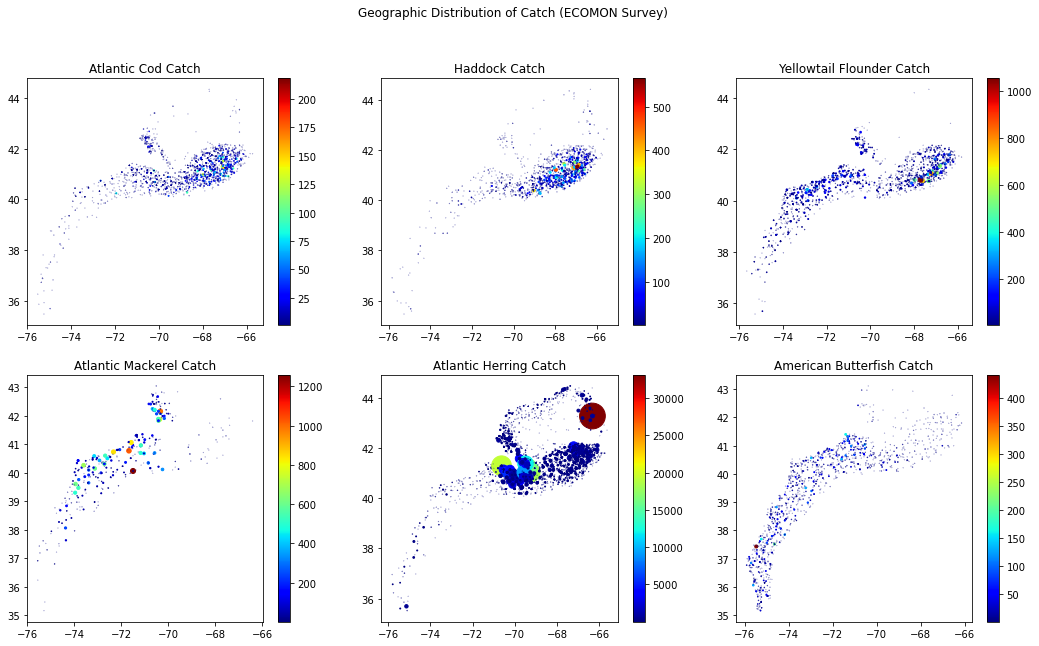

In [87]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    _, scatter = plot_catch(s, a, cmap="jet")
    plt.colorbar(scatter, ax=a)
    
fig.suptitle("Geographic Distribution of Catch (ECOMON Survey)")
filename = "../figs/env-params-dist/ecomon-catch-location.jpg"
#plt.savefig(filename, dpi=300)

This all looks generally good relative to what NOAA reports in the Habitat source sdocuments. The sparsity of the data for species like mackerel and butterfish is concerning, as is the overabundance of herring catch data. May make parameterizing a GAM more complicated.

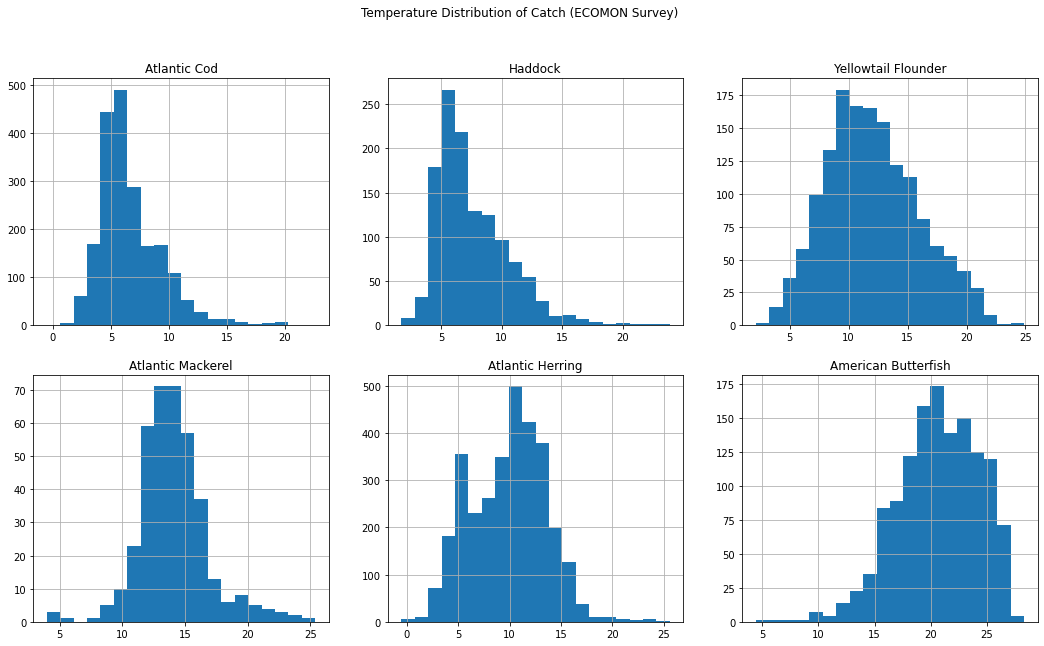

In [88]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    df = filter_by_species(ecomon_data_clean, s)
    df['sfc_temp'].hist(bins=20, ax=a)
    a.set_title("{}".format(s))

fig.suptitle("Temperature Distribution of Catch (ECOMON Survey)")
filename = "../figs/env-params-dist/ecomon-temp-dist.jpg"
#plt.savefig(filename, dpi=300)

Temperature distributions look generally correct with Cod and Haddock being the coldest, Butterfish the warmest, and the other three species more intermediate.

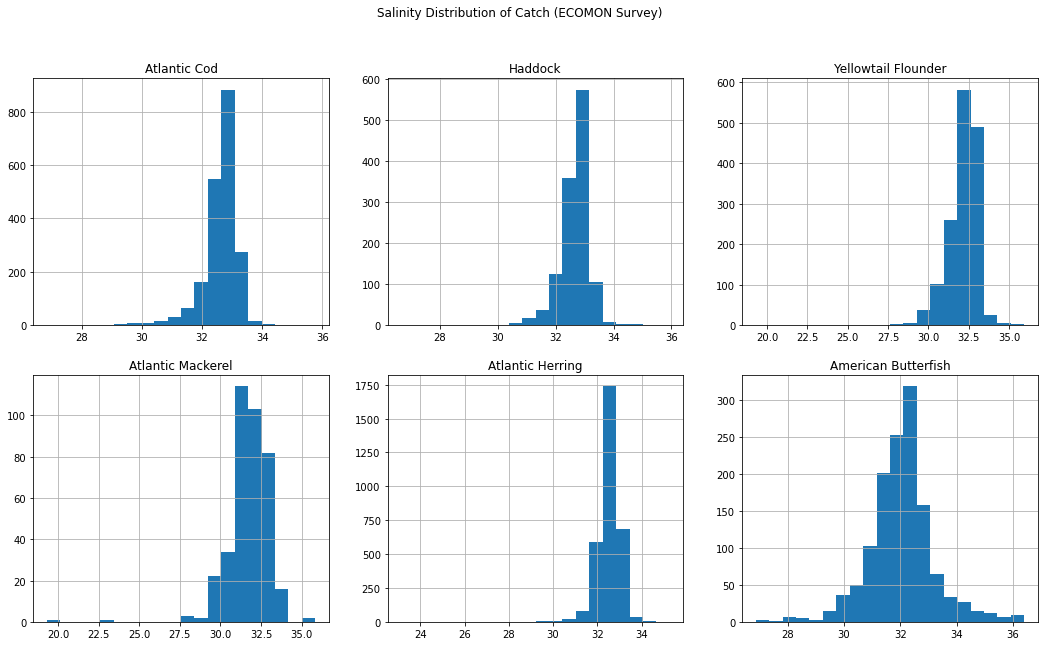

In [89]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    df = filter_by_species(ecomon_data_clean, s)
    df['sfc_salt'].hist(bins=20, ax=a)
    a.set_title("{}".format(s))
    
fig.suptitle("Salinity Distribution of Catch (ECOMON Survey)")
filename = "../figs/env-params-dist/ecomon-salin-dist.jpg"
#plt.savefig(filename, dpi=300)

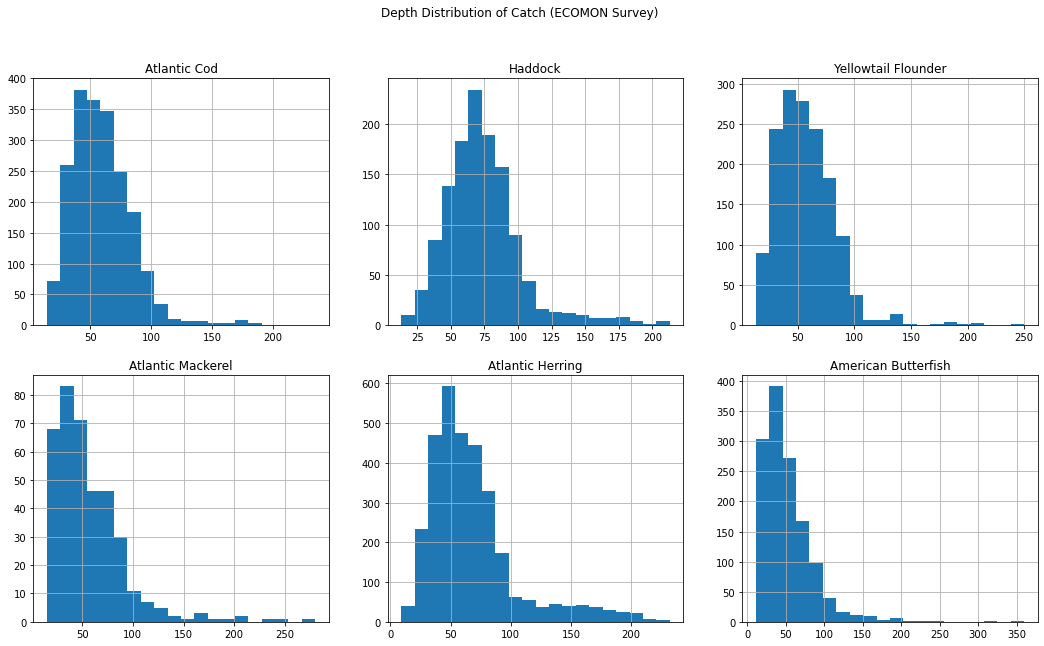

In [90]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    df = filter_by_species(ecomon_data_clean, s)
    df['depth'].hist(bins=20, ax=a)
    a.set_title("{}".format(s))
    
fig.suptitle("Depth Distribution of Catch (ECOMON Survey)")
filename = "../figs/env-params-dist/ecomon-depth-dist.jpg"
#plt.savefig(filename, dpi=300)

Seem generally correct relative to published data.

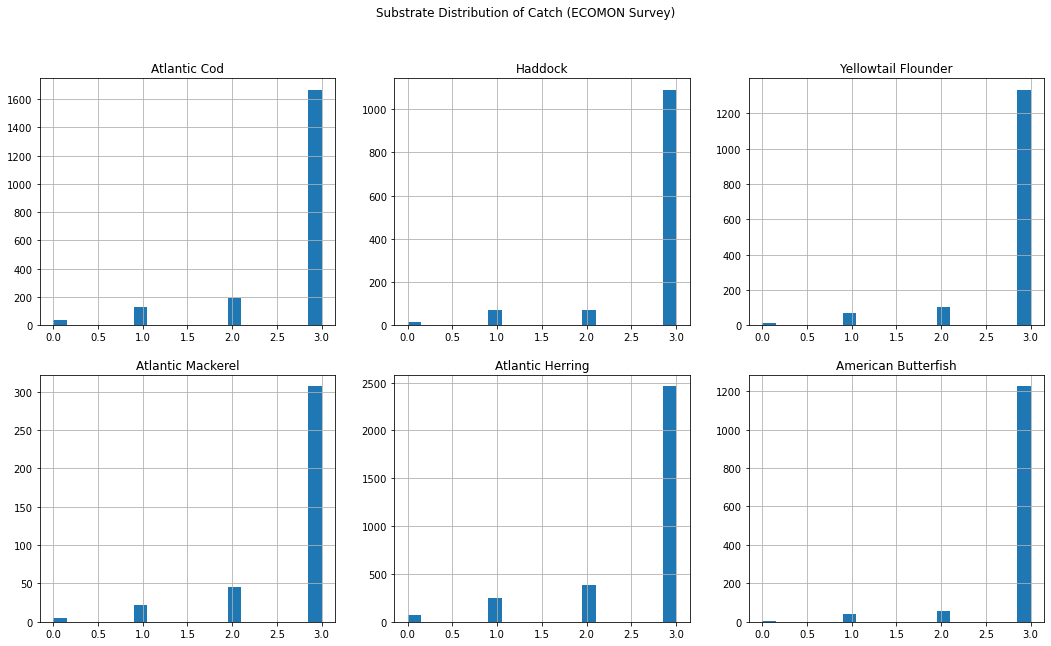

In [107]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    df = filter_by_species(ecomon_data_clean, s)
    df['btm_sub'].hist(bins=20, ax=a)
    a.set_title("{}".format(s))
    
fig.suptitle("Substrate Distribution of Catch (ECOMON Survey)")
filename = "../figs/env-params-dist/ecomon-substrate-dist.jpg"
plt.savefig(filename, dpi=300)

## Notes

All of the environmental distributions seems reasonably correct relative to published literature. The main concern I have with this dataset is the highly uneven sampling (why so many herring and so little mackerel?) and the general small amount of available data (compared to the NOAA dataset). The fact that we don't know what lifestage this catch is in is also not helpful, but we don't have that information from the NOAA data either.

In [109]:
data_columns = ['year', 'month', 'lat', 'lon', 'depth', 'btm_sub', 'sfc_temp', 'sfc_salt', 'btm_temp', 'btm_salt']
cod_data = ecomon_data_clean[data_columns+[ecomon_species_headings['Atlantic Cod']]]
had_data = ecomon_data_clean[data_columns+[ecomon_species_headings['Haddock']]]
flo_data = ecomon_data_clean[data_columns+[ecomon_species_headings['Yellowtail Flounder']]]
her_data = ecomon_data_clean[data_columns+[ecomon_species_headings['Atlantic Herring']]]
mac_data = ecomon_data_clean[data_columns+[ecomon_species_headings['Atlantic Mackerel']]]
but_data = ecomon_data_clean[data_columns+[ecomon_species_headings['American Butterfish']]]

In [110]:
filenamebase="../auxdata/catch-data/ecomon_"

cod_data.to_csv(filenamebase+"cod.csv")
had_data.to_csv(filenamebase+"haddock.csv")
flo_data.to_csv(filenamebase+"flounder.csv")
her_data.to_csv(filenamebase+"herring.csv")
mac_data.to_csv(filenamebase+"mackerel.csv")
but_data.to_csv(filenamebase+"butterfish.csv")

# NOAA Trawl Survey Data Preliminary Analysis

In [111]:
noaa_trawl_catch_data = pd.read_csv("../auxdata/noaa-trawl-data/22561_UNION_FSCS_SVCAT.csv") 
noaa_trawl_station_data = pd.read_csv("../auxdata/noaa-trawl-data/22561_UNION_FSCS_SVSTA.csv") 

/vortexfs1/home/jzahner/.conda/envs/ldm/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [112]:
noaa_trawl_catch_data['ID'] = noaa_trawl_catch_data.apply (lambda row: str(row['CRUISE6'])+"0"+str(row['STRATUM'])+str(row["TOW"]).zfill(3)+str(row["STATION"]).zfill(4), axis=1)
noaa_trawl_catch_data['ID'] = noaa_trawl_catch_data['ID'].astype("int64")

In [113]:
noaa_trawl_station_data.columns

Index(['CRUISE6', 'STRATUM', 'TOW', 'STATION', 'ID', 'AREA', 'SVVESSEL',
       'CRUNUM', 'SVGEAR', 'BEGIN_EST_TOWDATE', 'END_EST_TOWDATE',
       'BEGIN_GMT_TOWDATE', 'END_GMT_TOWDATE', 'EST_YEAR', 'EST_MONTH',
       'EST_DAY', 'EST_JULIAN_DAY', 'EST_TIME', 'GMT_YEAR', 'GMT_MONTH',
       'GMT_DAY', 'GMT_JULIAN_DAY', 'GMT_TIME', 'TOWDUR', 'SETDEPTH',
       'ENDDEPTH', 'MINDEPTH', 'MAXDEPTH', 'AVGDEPTH', 'BEGLAT', 'BEGLON',
       'ENDLAT', 'ENDLON', 'DECDEG_BEGLAT', 'DECDEG_BEGLON', 'DECDEG_ENDLAT',
       'DECDEG_ENDLON', 'CABLE', 'PITCH', 'HEADING', 'COURSE', 'RPM',
       'DOPDISTB', 'DOPDISTW', 'DESSPEED', 'AIRTEMP', 'CLOUD', 'BAROPRESS',
       'WINDDIR', 'WINDSP', 'WEATHER', 'WAVEHGT', 'SWELLDIR', 'SWELLHGT',
       'BKTTEMP', 'XBT', 'SURFTEMP', 'SURFSALIN', 'BOTTEMP', 'BOTSALIN'],
      dtype='object')

In [114]:
station_data_columns = ['ID', 'AVGDEPTH', 'DECDEG_BEGLAT', 'DECDEG_BEGLON', 'SURFTEMP', 'SURFSALIN', 'BOTTEMP', 'BOTSALIN', 'GMT_YEAR', 'GMT_MONTH']
catch_data_columns = ['ID', 'LOGGED_SPECIES_NAME', 'EXPCATCHNUM']

In [115]:
noaa_trawl_station_data_filtered = noaa_trawl_station_data[station_data_columns]
noaa_trawl_catch_data_filtered = noaa_trawl_catch_data[catch_data_columns]

noaa_trawl_catch_data_filtered = noaa_trawl_catch_data_filtered.set_index(["ID"])
noaa_trawl_station_data_filtered = noaa_trawl_station_data_filtered.set_index(["ID"])

In [135]:
noaa_trawl_data = noaa_trawl_catch_data_filtered.join(noaa_trawl_station_data_filtered)
noaa_trawl_data

,LOGGED_SPECIES_NAME,EXPCATCHNUM,AVGDEPTH,DECDEG_BEGLAT,DECDEG_BEGLON,SURFTEMP,SURFSALIN,BOTTEMP,BOTSALIN,GMT_YEAR,GMT_MONTH
ID,,,,,,,,,,,
196803010100010014,SPINY DOGFISH,1.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3
196803010100010014,LITTLE SKATE,6.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3
196803010100010014,ATLANTIC HERRING,272.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3
196803010100010014,ALEWIFE,2.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3
196803010100010014,SILVER HAKE,59.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3
...,...,...,...,...,...,...,...,...,...,...,...
201902085300020031,Congridae,1.0,298.0,34.856645,-75.381743,NaN,NaN,NaN,NaN,2019,3
201902085300020031,Illex illecebrosus (northern shortfin squid),52.0,298.0,34.856645,-75.381743,NaN,NaN,NaN,NaN,2019,3
201902085300020031,Loligo pealeii (longfin squid),21.0,298.0,34.856645,-75.381743,NaN,NaN,NaN,NaN,2019,3


In [136]:
def get_substrate_at_coord(row): 
    lat, lon = row['DECDEG_BEGLAT'], row['DECDEG_BEGLON']

    dist, idx = coord_tree.query([lon, lat])
    substrate = sub[idx].astype(int)
    return substrate

noaa_trawl_data['BOTTSUB'] = noaa_trawl_data.apply(lambda r: get_substrate_at_coord(r), axis=1)
noaa_trawl_data

,LOGGED_SPECIES_NAME,EXPCATCHNUM,AVGDEPTH,DECDEG_BEGLAT,DECDEG_BEGLON,SURFTEMP,SURFSALIN,BOTTEMP,BOTSALIN,GMT_YEAR,GMT_MONTH,BOTTSUB
ID,,,,,,,,,,,,
196803010100010014,SPINY DOGFISH,1.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3,3
196803010100010014,LITTLE SKATE,6.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3,3
196803010100010014,ATLANTIC HERRING,272.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3,3
196803010100010014,ALEWIFE,2.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3,3
196803010100010014,SILVER HAKE,59.0,40.0,39.783333,-73.333333,3.3,NaN,4.2,NaN,1968,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...
201902085300020031,Congridae,1.0,298.0,34.856645,-75.381743,NaN,NaN,NaN,NaN,2019,3,3
201902085300020031,Illex illecebrosus (northern shortfin squid),52.0,298.0,34.856645,-75.381743,NaN,NaN,NaN,NaN,2019,3,3
201902085300020031,Loligo pealeii (longfin squid),21.0,298.0,34.856645,-75.381743,NaN,NaN,NaN,NaN,2019,3,3


In [137]:
filename = "../auxdata/noaa-trawl-data/catch-station-data.csv"
noaa_trawl_data.to_csv(filename)

In [124]:
noaa_species_headings = {
    "Atlantic Cod": "ATLANTIC COD",
    "Haddock": "HADDOCK",
    "Yellowtail Flounder": "YELLOWTAIL FLOUNDER",
    "Atlantic Mackerel": "ATLANTIC MACKEREL",
    "Atlantic Herring": "ATLANTIC HERRING",
    "American Butterfish": "BUTTERFISH"
}

In [125]:
noaa_trawl_data = noaa_trawl_data[noaa_trawl_data['LOGGED_SPECIES_NAME'].isin(noaa_species_headings.values())]

In [126]:
def filter_by_species(df, species):
    s = noaa_species_headings[species]
    processed_df = df[df['LOGGED_SPECIES_NAME'] == s]
    return processed_df

def weighted_histogram(species, parameter):
    df = filter_by_species(noaa_trawl_data, species)
    catch = df["EXPCATCHNUM"].fillna(0)
    param = df[parameter]
    
    vals = np.repeat(param, catch)
    return pd.Series(vals)

In [127]:
def plot_catch(species, ax=None, cmap='viridis'):
    df = filter_by_species(noaa_trawl_data, species)
    lats, lons, catch = df['DECDEG_BEGLAT'], df['DECDEG_BEGLON'], df['EXPCATCHNUM']
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    
    scatter = ax.scatter(lons, lats, c=catch, s=catch/50, cmap=cmap)
    ax.set_title("{} Catch".format(species))
    
    return ax, scatter

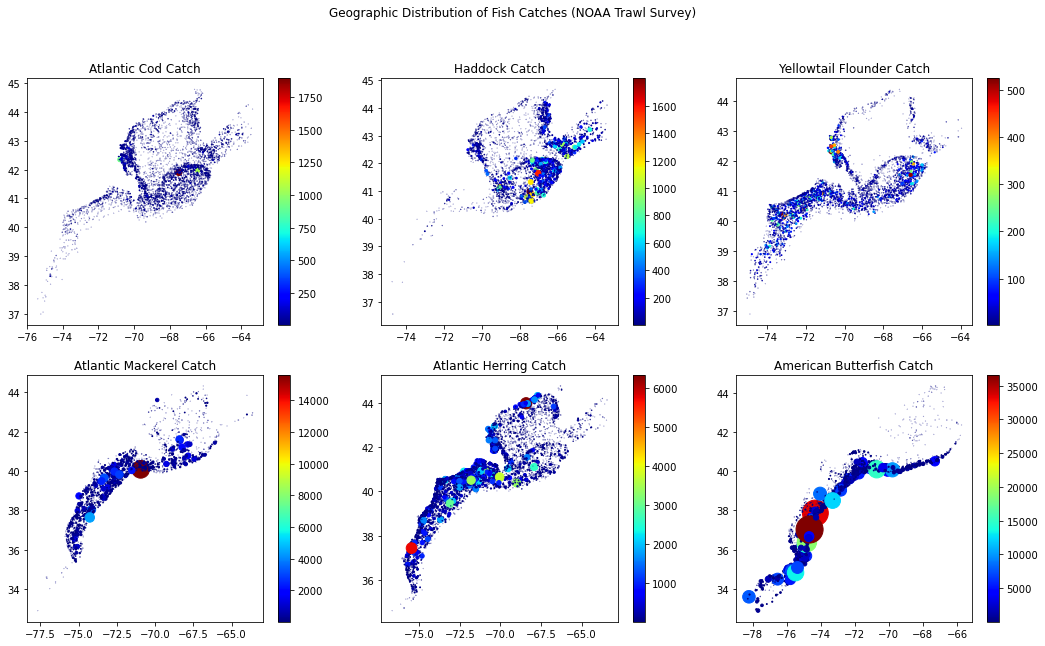

In [129]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    _, scatter = plot_catch(s, a, cmap="jet")
    plt.colorbar(scatter, ax=a)
    
fig.suptitle("Geographic Distribution of Fish Catches (NOAA Trawl Survey)")

filename = "../figs/env-params-dist/noaa-survey-catch-location.jpg"
#plt.savefig(filename, dpi=300)

These look good relative to the NOAA published data.

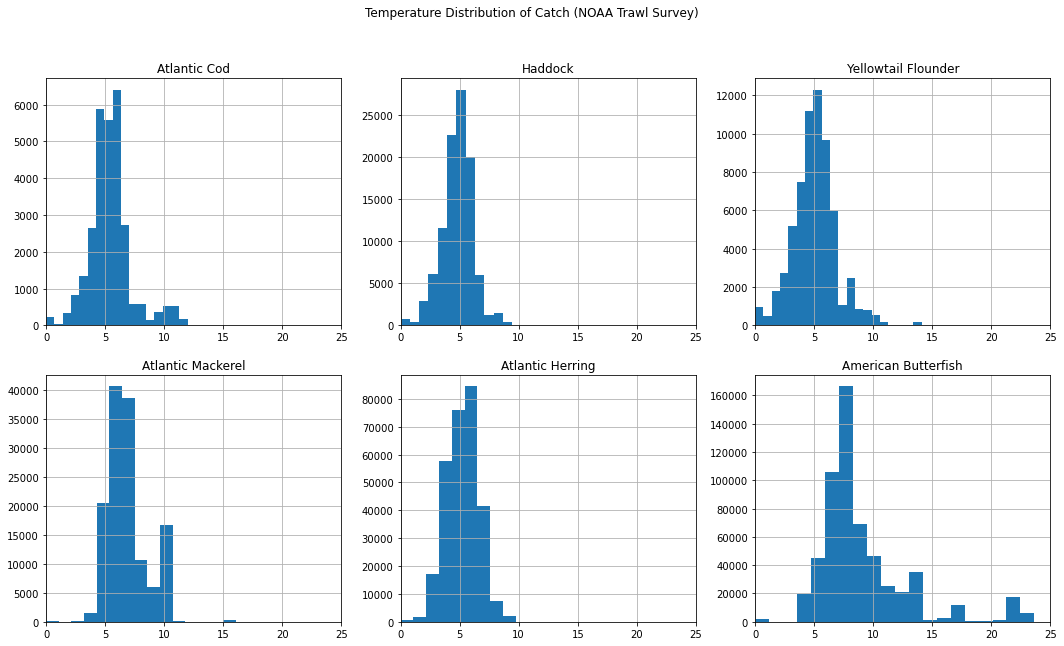

In [130]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    temps = weighted_histogram(s, "SURFTEMP")
    temps.hist(bins=20, ax=a)
    a.set_title("{}".format(s))
    a.set_xlim((0, 25))
    
fig.suptitle("Temperature Distribution of Catch (NOAA Trawl Survey)")

filename = "../figs/env-params-dist/noaa-survey-temp-dist.jpg"
#plt.savefig(filename, dpi=300)

These plots look suspect to me, as they are showing similar mean temperatures for all species, which we know not to be the case. Need to look at this a bit closer imo. 

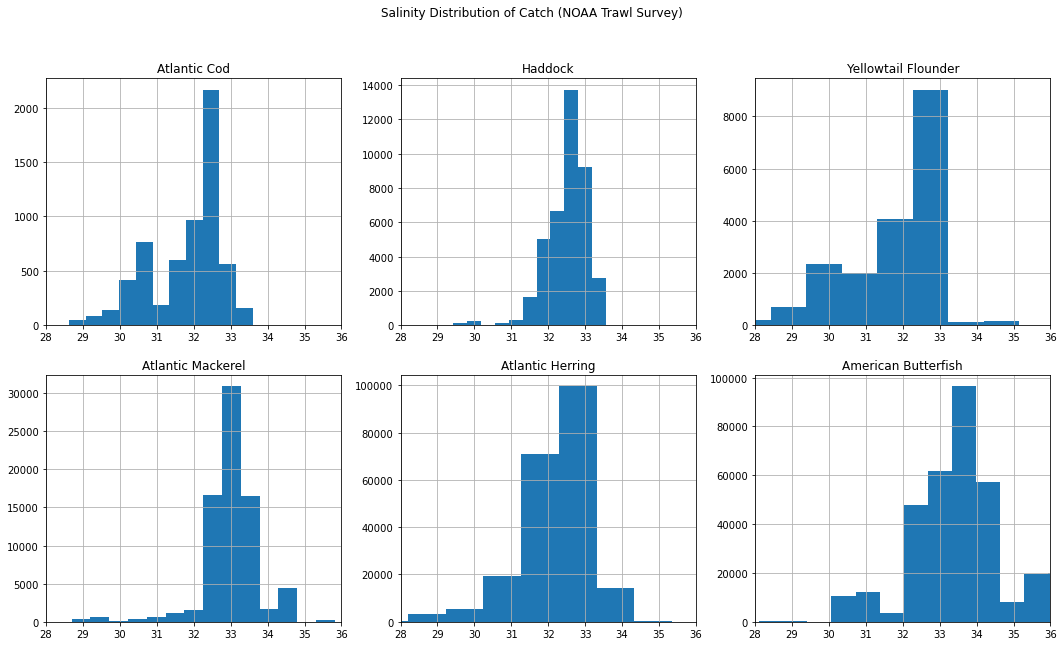

In [131]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    sal = weighted_histogram(s, "SURFSALIN")
    sal.hist(bins=20, ax=a)
    a.set_title("{}".format(s))
    a.set_xlim(28, 36)
    
fig.suptitle("Salinity Distribution of Catch (NOAA Trawl Survey)")

filename = "../figs/env-params-dist/noaa-survey-salin-dist.jpg"
#plt.savefig(filename, dpi=300)

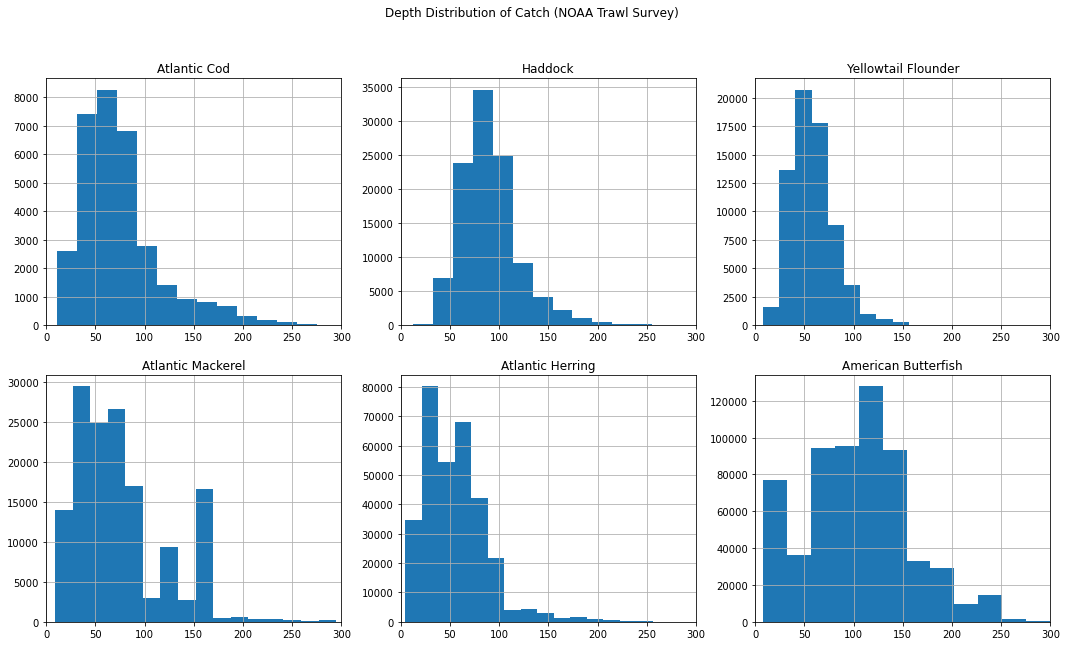

In [132]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    depths = weighted_histogram(s, "AVGDEPTH")
    depths.hist(bins=20, ax=a)
    a.set_title("{}".format(s))
    a.set_xlim((0, 300))
    
fig.suptitle("Depth Distribution of Catch (NOAA Trawl Survey)")

filename = "../figs/env-params-dist/noaa-survey-depth-dist.jpg"
#plt.savefig(filename, dpi=300)

These seem legitimate relative to published data.

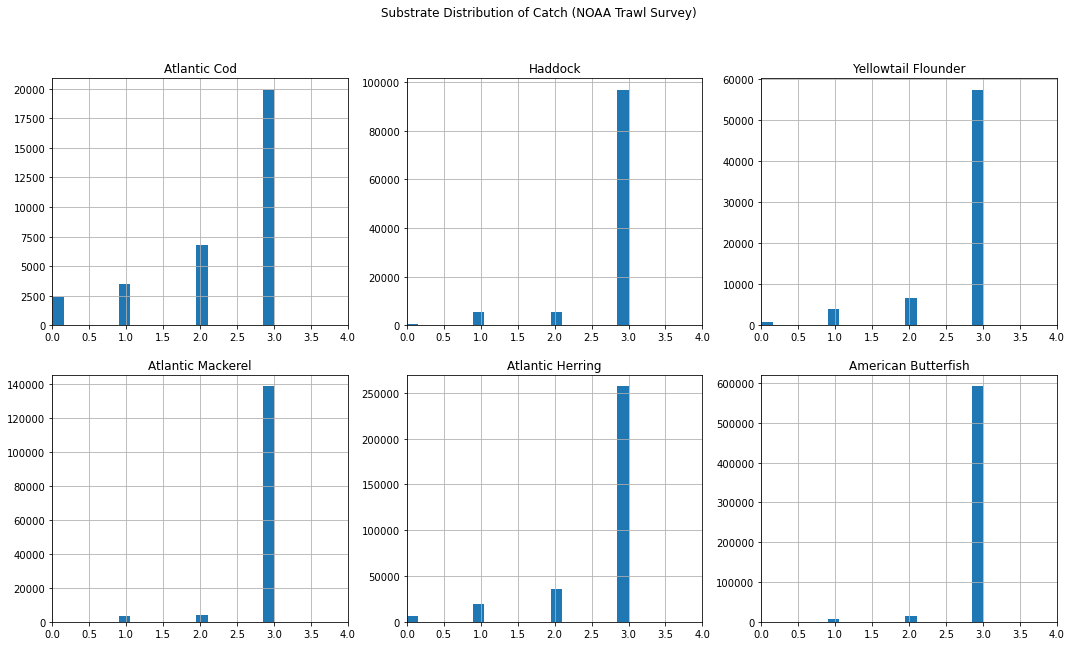

In [139]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

axes = ax.ravel()

for s, a in zip(ecomon_species_headings.keys(), axes):
    depths = weighted_histogram(s, "BOTTSUB")
    depths.hist(bins=20, ax=a)
    a.set_title("{}".format(s))
    a.set_xlim((0, 4))
    
fig.suptitle("Substrate Distribution of Catch (NOAA Trawl Survey)")

filename = "../figs/env-params-dist/noaa-survey-substrate-dist.jpg"
plt.savefig(filename, dpi=300)

## Notes

We have some problems with the NOAA data. 

Notable, the temperature distributions seem non realistic based on what we know about the habitat preferences for each species. The NOAA data shows all five species have a mean catch temperature of 5-8˚C, which is 100% inconsistent with the Habitat Source Documents and the ECOMON data which displays what I would consider to be the correct thermal distributions. This is all due to the sampling time period of the NOAA data. The NOAA data is collected between February and May every year, and thus water temperature are only reflective of those months. This could significantly skew any results of a GAM, as some species, such as mackerel and butterfish don't even spawn during those months, so there is no realistic way to use this environmental data to properly model spawning suitability.

The salinity and depth profiles look largely as one would expect, and are similar to those prodcued by the ECOMON dataset. I have no further comments on them.

The big problem we are going to get into by using the NOAA data is that there appears to be very little difference in the habitat preferences for each species. When we go to build a GAM for each species, the modeled spawning habitat suitability is going to look very similiar for all of them, unless latitude and longitude are stringly weighted (possible).

In [140]:
cols = ['GMT_YEAR', 'GMT_MONTH', 'AVGDEPTH', 'DECDEG_BEGLAT', 'DECDEG_BEGLON', 'SURFTEMP', 'SURFSALIN', 'BOTTEMP', 'BOTSALIN', 'BOTTSUB']
noaa_trawl_data = noaa_trawl_data[cols+['LOGGED_SPECIES_NAME', 'EXPCATCHNUM']]


cod_data = filter_by_species(noaa_trawl_data, 'Atlantic Cod')
had_data = filter_by_species(noaa_trawl_data, 'Haddock')
flo_data = filter_by_species(noaa_trawl_data, 'Yellowtail Flounder')
her_data = filter_by_species(noaa_trawl_data, 'Atlantic Herring')
mac_data = filter_by_species(noaa_trawl_data, 'Atlantic Mackerel')
but_data = filter_by_species(noaa_trawl_data, 'American Butterfish')

In [141]:
but_data

,GMT_YEAR,GMT_MONTH,AVGDEPTH,DECDEG_BEGLAT,DECDEG_BEGLON,SURFTEMP,SURFSALIN,BOTTEMP,BOTSALIN,BOTTSUB,LOGGED_SPECIES_NAME,EXPCATCHNUM
ID,,,,,,,,,,,,
196803010200010075,1968,3,106.0,39.283333,-72.750000,5.00,NaN,8.70,NaN,3,BUTTERFISH,5.0
196803010200040084,1968,3,80.0,39.983333,-72.116667,4.00,NaN,8.00,NaN,3,BUTTERFISH,17.0
196803010300020074,1968,3,117.0,39.366667,-72.616667,7.00,NaN,10.00,NaN,3,BUTTERFISH,11.0
196803010300040082,1968,3,148.0,39.566667,-72.183333,4.50,NaN,11.00,NaN,2,BUTTERFISH,29.0
196803010400020078,1968,3,191.0,39.300000,-72.366667,5.30,NaN,10.90,NaN,3,BUTTERFISH,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
201001085200010060,2010,3,136.0,34.866270,-75.440717,22.01,36.578,16.09,35.881,3,BUTTERFISH,535.0
201001085200020057,2010,3,166.0,34.486212,-75.781327,22.57,36.592,18.04,36.489,3,BUTTERFISH,5409.0
201001085200030059,2010,3,140.0,34.829853,-75.477840,22.28,36.574,17.75,36.225,3,BUTTERFISH,13446.0


In [142]:
filenamebase="../auxdata/catch-data/noaa_"

cod_data.to_csv(filenamebase+"cod.csv")
had_data.to_csv(filenamebase+"haddock.csv")
flo_data.to_csv(filenamebase+"flounder.csv")
her_data.to_csv(filenamebase+"herring.csv")
mac_data.to_csv(filenamebase+"mackerel.csv")
but_data.to_csv(filenamebase+"butterfish.csv")